In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from math import sqrt
import seaborn as sns; sns.set()
from imblearn.over_sampling import SMOTE, ADASYN


from technicalSignals import momentum,SMA,inBBands


In [2]:
tickers=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX']

TREND_WINDOWs = [(-48,0),(-35,0),(-28,0),(-7,0),(-1,0),(1,2),(1,8),(1,29),(1,36),(1,50)]
kind_of_dataset = 'AffectiveSpace'


In [3]:
class DatasetManager:
    def __init__(self):
        X_raw = None
        Y_raw = None
        Y = None
        X = None
        cum_ret = None
    
    def load_dataset(self, ticker, kind, technicalFeatures=False):
        types = {'Summary': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentFullAggregatedHourly/',
            'AffectiveSpace': '/home/simone/Desktop/NLFF/AffectiveSpace/Aggregated_AffectSummary_dataset/',
            'Title': '/home/simone/Desktop/NLFF/intrinioDatasetUpdated/SentimentTitleAggregatedHourly/',
            'Senticnet':''}
        news =  pd.read_csv(types[kind]+ticker+'.csv')
        price = pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexes'+ticker+'.csv')
        price = price.rename(index=str, columns={"date": "DATE"})
        news = news.rename(index=str, columns={"initTime": "DATE"})
        news = news.drop(['Unnamed: 0'], axis=1)
        news['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in news['DATE']]
        # This datased is already GMT+0
        price['DATE'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['DATE']]
        if(technicalFeatures):
            price['mom_30'] = momentum(price, 30)
            price['mom_50'] = momentum(price, 50)
            price['mom_100'] = momentum(price, 100)
            price['mom_150'] = momentum(price, 150)
            price['SMA_30'] = SMA(price, 30)
            price['SMA_50'] = SMA(price, 50)
            price['SMA_100'] = SMA(price, 100)
            price['SMA_150'] = SMA(price, 150)
            price['in_BBands'] = inBBands(price)

        #ALLIGNMENT
        initDate = max(news['DATE'][0], datetime(2017, 5, 22, 0, 0, 0))
        finalDate = min(news['DATE'][len(news)-1],datetime(2018, 6, 21, 0, 0, 0))
        news.drop(news[news.DATE > finalDate].index, inplace=True)
        news.drop(news[news.DATE < initDate].index, inplace=True)
        news = news.reset_index(drop=True)
        price.drop(price[price.DATE > finalDate].index, inplace=True)
        price.drop(price[price.DATE < initDate].index, inplace=True)
        price = price.reset_index(drop=True)
        assert len(price) == len(news)
        # FEATURES
        sentiment = news.drop(['DATE'], axis=1)
        X = sentiment
        for window in [5,10,15,20,30,50]:
            temp = sentiment.rolling(window).mean()
            temp.columns = temp.columns +'_'+str(window)
            X = pd.concat([X, temp],axis=1)
        if(technicalFeatures):   
            technical_features = ['mom_30','mom_50','mom_100','mom_150','SMA_30','SMA_50','SMA_100','SMA_150','in_BBands']
            X = pd.concat([X, price[technical_features]],axis=1)

            
        #NORMALIZATION:
        min_max_scaler = preprocessing.MinMaxScaler()
        X = np.nan_to_num(np.asarray(X, dtype=float))
        X = np.asarray(min_max_scaler.fit_transform(X))
        self.X_raw = X
        self.Y_raw = price

    def get_dataset_for_trend(self, init, finish, perc_train = 0.7):
        y = list()
        x = list()
        dates = list()
        price = self.Y_raw
        for i in range(abs(init),len(price)-finish):
            cumulative_return =  (price.iloc[i+finish]['open']-price.iloc[i+init]['open'])/price.iloc[i+init]['open']
            y.append(0 if cumulative_return<0 else 1)
            dates.append(price.iloc[i]['DATE'])
            x.append(self.X_raw[i])
        
       #y = self.normalize(np.array(y))
        y = np.array(y)
        x = np.array(x)
        self.X = x
        self.Y = y
        nt=math.ceil(len(x)*perc_train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        dates_test = dates[nt:]
        return (x_tv,y_tv),(x_test,y_test),dates_test
    


def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled


In [4]:

model_selection_values = {
    #(tick, init, finish): (best_c, best_gamma)
    ('AAPL',-48,0):(0.01, 0.004520353656360245),
    ('AAPL',-35,0):(7.880462815669913,0.0014873521072935117),
    ('AAPL',-28,0):(0.2807216203941177,0.007880462815669913),
    ('AAPL',-7,0):(0.2807216203941177,0.12689610031679235),
    ('AAPL',-1,0):(32903.44562312671, 1.7433288221999873e-05),
    ('AAPL',1,2):(0.853167852417281,0.013738237958832637),
    ('AAPL',1,8):(3562.2478902624443, 1e-05),
    ('AAPL',1,29):(221.22162910704503,0.22122162910704501),
    ('AAPL',1,36):(0.4893900918477494,0.002592943797404667),
    ('AAPL',1,50):(0.017433288221999882,0.04175318936560404),
    
    ('AMZN',-48,0):(126.89610031679234,0.007880462815669913),
    ('AMZN',-35,0):(0.4893900918477494,0.02395026619987486),
    ('AMZN',-28,0):(0.16102620275609392,  0.013738237958832637),
    ('AMZN',-7,0):(0.16102620275609392,  0.07278953843983153),
    ('AMZN',-1,0):(72.78953843983153,  0.04175318936560404),
    ('AMZN',1,2):(6210.169418915616,  0.00016102620275609394),
    ('AMZN',1,8):(0.017433288221999882,  0.38566204211634725),
    ('AMZN',1,29):(0.03039195382313198,  0.12689610031679235),
    ('AMZN',1,36):(0.05298316906283707,  0.12689610031679235),
    ('AMZN',1,50):(41.753189365604044 , 9.236708571873866e-05),
    
    ('GOOGL',-48,0):(0.853167852417281 ,  0.004520353656360245),
    ('GOOGL',-35,0):(0.09236708571873865 ,0.12689610031679235),
    ('GOOGL',-28,0):(7.880462815669913  , 0.0008531678524172815),
    ('GOOGL',-7,0):(385.6620421163472 , 1e-05),
    ('GOOGL',-1,0):(2043.3597178569437  ,  0.0002807216203941176),
    ('GOOGL',1,2):(672.3357536499335  ,  5.2983169062837125e-05),
    ('GOOGL',1,8):(0.2807216203941177 , 0.02395026619987486),
    ('GOOGL',1,29):(7.880462815669913  , 0.007880462815669913),
    ('GOOGL',1,36):(18873.918221350996 ,  5.2983169062837125e-05),
    ('GOOGL',1,50):(126.89610031679234 ,  0.12689610031679235),
    
    ('MSFT',-48,0):( 0.05298316906283707,0.02395026619987486),
    ('MSFT',-35,0):(0.05298316906283707,0.013738237958832637),
    ('MSFT',-28,0):( 0.853167852417281,0.007880462815669913),
    ('MSFT',-7,0):( 0.4893900918477494 , 0.07278953843983153),
    ('MSFT',-1,0):(  2043.3597178569437 , 0.38566204211634725),
    ('MSFT',1,2):(0.05298316906283707 ,  0.07278953843983153),
    ('MSFT',1,8):( 7.880462815669913 ,  0.0008531678524172815),
    ('MSFT',1,29):( 0.16102620275609392  , 0.12689610031679235),
    ('MSFT',1,36):(0.09236708571873865 , 0.12689610031679235),
    ('MSFT',1,50):(0.09236708571873865  ,  0.12689610031679235),
    
    ('FB',-48,0):( 0.05298316906283707 ,  0.007880462815669913),
    ('FB',-35,0):(221.22162910704503  ,  1.7433288221999873e-05),
    ('FB',-28,0):( 13.738237958832638  ,  0.0004893900918477494),
    ('FB',-7,0):( 126.89610031679234  ,  0.004520353656360245),
    ('FB',-1,0):( 13.738237958832638  , 0.002592943797404667),
    ('FB',1,2):(72.78953843983153  , 0.0002807216203941176),
    ('FB',1,8):(221.22162910704503 , 1.7433288221999873e-05),
    ('FB',1,29):(57361.52510448681  ,  5.2983169062837125e-05),
    ('FB',1,36):( 1.4873521072935119  , 0.0014873521072935117),
    ('FB',1,50):(2.592943797404667 , 0.004520353656360245),
    
    ('INTC',-48,0):(  0.16102620275609392, 0.02395026619987486),
    ('INTC',-35,0):(4.520353656360245 , 0.0004893900918477494),
    ('INTC',-28,0):(1.4873521072935119 ,  0.0014873521072935117),
    ('INTC',-7,0):(72.78953843983153 ,0.007880462815669913),
    ('INTC',-1,0):(6210.169418915616 , 0.00016102620275609394),
    ('INTC',1,2):(72.78953843983153 , 9.236708571873866e-05),
    ('INTC',1,8):(2.592943797404667 ,  0.07278953843983153),
    ('INTC',1,29):(3562.2478902624443 , 3.039195382313195e-05),
    ('INTC',1,36):(  32903.44562312671 ,  0.0002807216203941176),
    ('INTC',1,50):(10826.36733874054 ,  0.00016102620275609394),
    
    ('CSCO',-48,0):( 2043.3597178569437, 1e-05),
    ('CSCO',-35,0):(41.753189365604044,  0.0008531678524172815),
    ('CSCO',-28,0):(221.22162910704503,  5.2983169062837125e-05),
    ('CSCO',-7,0):( 3562.2478902624443,  1.7433288221999873e-05),
    ('CSCO',-1,0):(7.880462815669913,  0.07278953843983153),
    ('CSCO',1,2):(221.22162910704503,  0.02395026619987486),
    ('CSCO',1,8):( 6210.169418915616, 0.002592943797404667),
    ('CSCO',1,29):(0.4893900918477494, 3.039195382313195e-05),
    ('CSCO',1,36):(0.16102620275609392 ,0.07278953843983153),
    ('CSCO',1,50):(18873.918221350996  , 0.07278953843983153),
    
    ('CMCSA',-48,0):( 221.22162910704503,  0.0002807216203941176),
    ('CMCSA',-35,0):(10826.36733874054,  1e-05),
    ('CMCSA',-28,0):(0.853167852417281, 0.004520353656360245),
    ('CMCSA',-7,0):(10826.36733874054, 5.2983169062837125e-05),
    ('CMCSA',-1,0):(10826.36733874054,  1e-05),
    ('CMCSA',1,2):( 2.592943797404667, 0.6723357536499335),
    ('CMCSA',1,8):(672.3357536499335,  0.02395026619987486),
    ('CMCSA',1,29):(0.2807216203941177,  0.12689610031679235),
    ('CMCSA',1,36):(0.03039195382313198,  0.07278953843983153),
    ('CMCSA',1,50):(100000.0,  0.04175318936560404),
    
    ('NVDA',-48,0):(  6210.169418915616, 5.2983169062837125e-05),
    ('NVDA',-35,0):( 221.22162910704503, 1e-05),
    ('NVDA',-28,0):(126.89610031679234, 5.2983169062837125e-05),
    ('NVDA',-7,0):(10826.36733874054, 1e-05),
    ('NVDA',-1,0):(2043.3597178569437, 0.00016102620275609394),
    ('NVDA',1,2):( 32903.44562312671, 0.0008531678524172815),
    ('NVDA',1,8):(672.3357536499335, 3.039195382313195e-05),
    ('NVDA',1,29):(0.017433288221999882, 0.04175318936560404),
    ('NVDA',1,36):( 0.01,  0.07278953843983153),
    ('NVDA',1,50):(.017433288221999882, 0.07278953843983153),
    
    ('NFLX',-48,0):(  0.03039195382313198,  0.0008531678524172815),
    ('NFLX',-35,0):(4.520353656360245, 0.0008531678524172815),
    ('NFLX',-28,0):(126.89610031679234,  3.039195382313195e-05),
    ('NFLX',-7,0):(18873.918221350996,  3.039195382313195e-05),
    ('NFLX',-1,0):(2043.3597178569437,  0.00016102620275609394),
    ('NFLX',1,2):( 672.3357536499335, 0.22122162910704501),
    ('NFLX',1,8):(385.6620421163472  ,  0.004520353656360245),
    ('NFLX',1,29):(0.16102620275609392 ,  0.07278953843983153),
    ('NFLX',1,36):(13.738237958832638 ,  0.0002807216203941176),
    ('NFLX',1,50):(57361.52510448681 ,  0.07278953843983153)

    }

In [5]:
def cv(x_tv,y_tv):
    best_mcc = -float(np.inf)
    best_c = 0
    best_g = 0
    for c in np.logspace(-2,5,30):
        for g in np.logspace(-5,2,30):
            print('.', end='')
            trainpoint=math.floor(len(x_tv)*0.50)
            dimval=math.floor(trainpoint*0.25)
            endval=trainpoint+dimval
            #Cross validation
            cvMCC = 0
            for i in range(0,4):
                x_train=x_tv[0:trainpoint]
                y_train=y_tv[0:trainpoint]
                x_val=x_tv[trainpoint:endval]
                y_val=y_tv[trainpoint:endval]
                trainpoint=trainpoint+dimval
                endval=endval+dimval
                if ((sum(y_val)+6<len(x_val) and sum(y_val)>6)):
                    x_train,y_train=smote(x_train,y_train)
                    x_val,y_val=smote(x_val,y_val)
                svm_model = svm.SVC(kernel='rbf', C=c, gamma=g)
                svm_model.fit(x_train,y_train)
                y_pred = svm_model.predict(x_val)
                confmatrix = confusion_matrix(y_val, y_pred)
                tn, fp, fn, tp = confmatrix.ravel()
                denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
                mcc = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom)
                cvMCC += mcc/4

            if(cvMCC > best_mcc):
                best_mcc = cvMCC
                best_c = c
                best_g = g
    return (best_c,best_g)




==================== AAPL ==================== 



trend:  -48   0
Best C:  0.01  best gamma:  0.004520353656360245

tn, fp, fn, tp:  [143  87  53 273]
trend:  -35   0
Best C:  7.880462815669913  best gamma:  0.0014873521072935117

tn, fp, fn, tp:  [163  98  36 263]
trend:  -28   0
Best C:  0.2807216203941177  best gamma:  0.007880462815669913

tn, fp, fn, tp:  [209  63  45 245]
trend:  -7   0
Best C:  0.2807216203941177  best gamma:  0.12689610031679235

tn, fp, fn, tp:  [141 115  93 219]
trend:  -1   0
Best C:  32903.44562312671  best gamma:  1.7433288221999873e-05

tn, fp, fn, tp:  [117 144  88 221]
trend:  1   2
Best C:  0.853167852417281  best gamma:  0.013738237958832637

tn, fp, fn, tp:  [118 142 127 182]
trend:  1   8
Best C:  3562.2478902624443  best gamma:  1e-05

tn, fp, fn, tp:  [171  85 193 118]
trend:  1   29
Best C:  221.22162910704503  best gamma:  0.22122162910704501

tn, fp, fn, tp:  [141 131  73 216]
trend:  1   36
Best C:  0.4893900918477494  best gamma:  0.00259

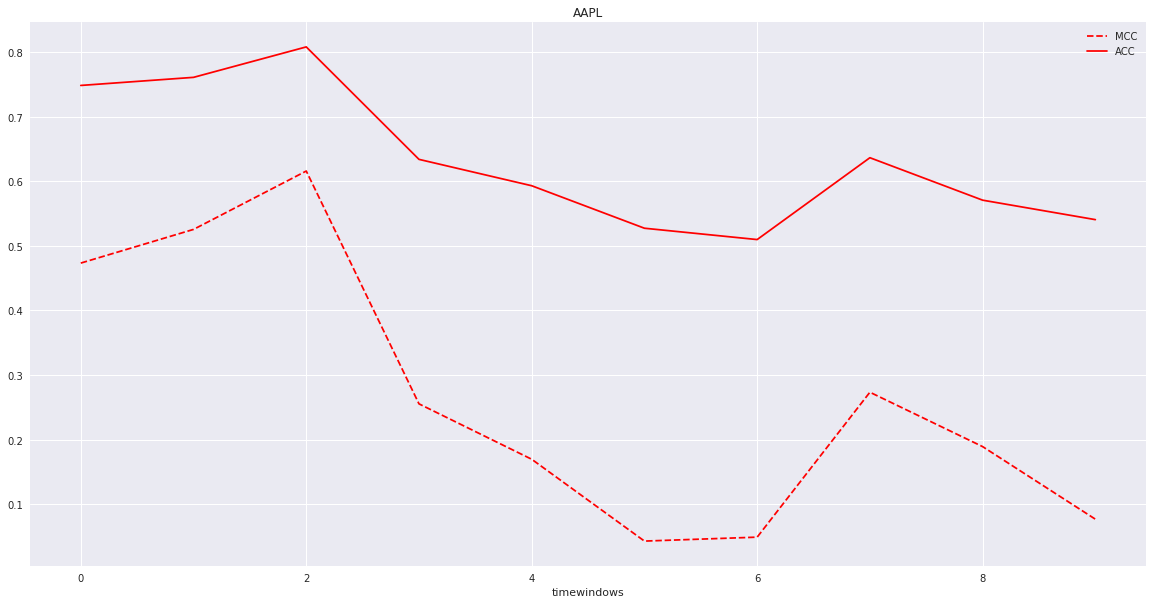




==================== AMZN ==================== 



trend:  -48   0
Best C:  126.89610031679234  best gamma:  0.007880462815669913

tn, fp, fn, tp:  [ 96  63  58 339]
trend:  -35   0
Best C:  0.4893900918477494  best gamma:  0.02395026619987486

tn, fp, fn, tp:  [154  17  62 327]
trend:  -28   0
Best C:  0.16102620275609392  best gamma:  0.013738237958832637

tn, fp, fn, tp:  [168  19  56 319]
trend:  -7   0
Best C:  0.16102620275609392  best gamma:  0.07278953843983153

tn, fp, fn, tp:  [107 129  72 260]
trend:  -1   0
Best C:  72.78953843983153  best gamma:  0.04175318936560404

tn, fp, fn, tp:  [159 102 154 155]
trend:  1   2
Best C:  6210.169418915616  best gamma:  0.00016102620275609394

tn, fp, fn, tp:  [ 85 176  97 211]
trend:  1   8
Best C:  0.017433288221999882  best gamma:  0.38566204211634725

tn, fp, fn, tp:  [ 22 214  41 290]
trend:  1   29
Best C:  0.03039195382313198  best gamma:  0.12689610031679235

tn, fp, fn, tp:  [142  45 246 128]
trend:  1   36
Best C:  0.0529831

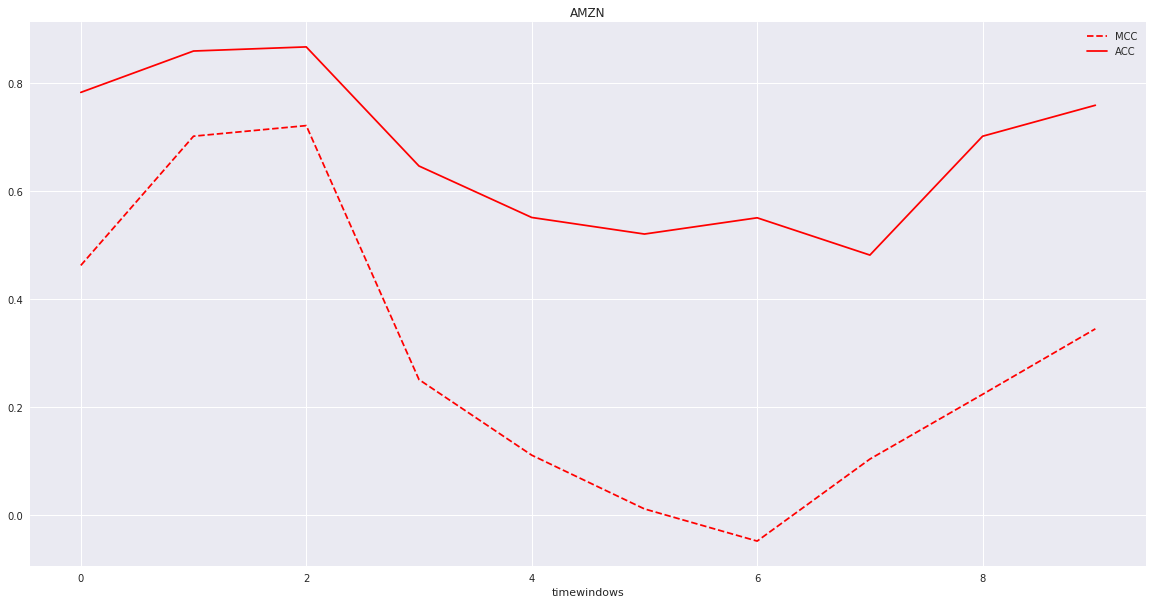




==================== GOOGL ==================== 



trend:  -48   0
Best C:  0.853167852417281  best gamma:  0.004520353656360245

tn, fp, fn, tp:  [215  37  62 242]
trend:  -35   0
Best C:  0.09236708571873865  best gamma:  0.12689610031679235

tn, fp, fn, tp:  [232  25  43 260]
trend:  -28   0
Best C:  7.880462815669913  best gamma:  0.0008531678524172815

tn, fp, fn, tp:  [232  30  55 245]
trend:  -7   0
Best C:  385.6620421163472  best gamma:  1e-05

tn, fp, fn, tp:  [159 107 109 193]
trend:  -1   0
Best C:  2043.3597178569437  best gamma:  0.0002807216203941176

tn, fp, fn, tp:  [113 157 103 197]
trend:  1   2
Best C:  672.3357536499335  best gamma:  5.2983169062837125e-05

tn, fp, fn, tp:  [104 166 103 196]
trend:  1   8
Best C:  0.2807216203941177  best gamma:  0.02395026619987486

tn, fp, fn, tp:  [142 124 142 159]
trend:  1   29
Best C:  7.880462815669913  best gamma:  0.007880462815669913

tn, fp, fn, tp:  [ 88 174  83 216]
trend:  1   36
Best C:  18873.918221350996  best 

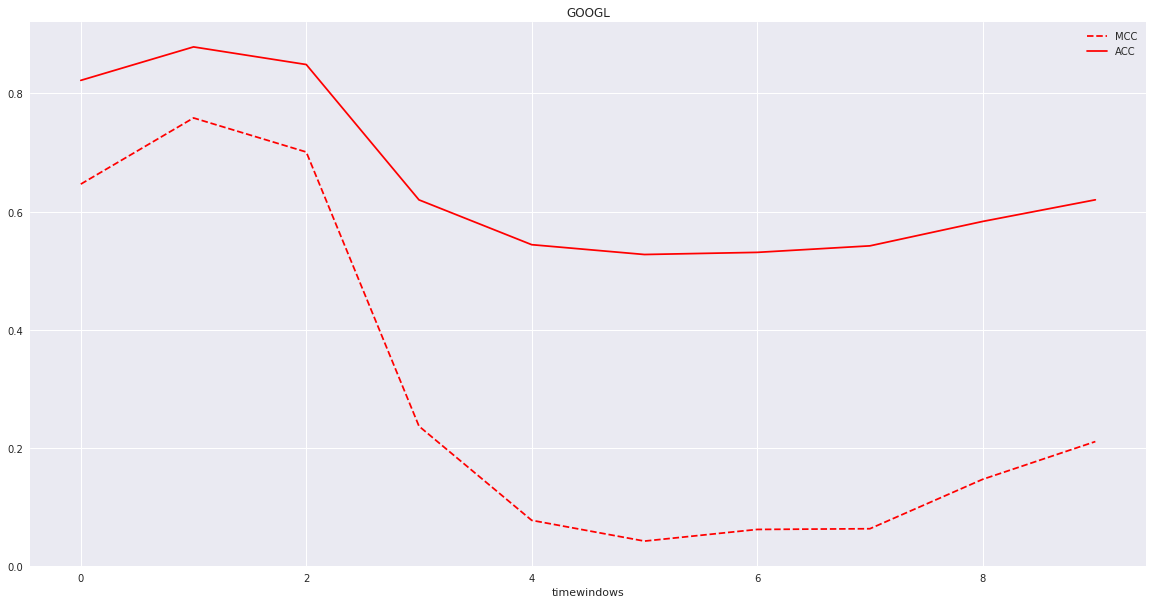




==================== MSFT ==================== 



trend:  -48   0
Best C:  0.05298316906283707  best gamma:  0.02395026619987486

tn, fp, fn, tp:  [176  33 109 238]
trend:  -35   0
Best C:  0.05298316906283707  best gamma:  0.013738237958832637

tn, fp, fn, tp:  [207  18 121 214]
trend:  -28   0
Best C:  0.853167852417281  best gamma:  0.007880462815669913

tn, fp, fn, tp:  [214  25  63 260]
trend:  -7   0
Best C:  0.4893900918477494  best gamma:  0.07278953843983153

tn, fp, fn, tp:  [171  79 132 186]
trend:  -1   0
Best C:  2043.3597178569437  best gamma:  0.38566204211634725

tn, fp, fn, tp:  [ 49 210  50 261]
trend:  1   2
Best C:  0.05298316906283707  best gamma:  0.07278953843983153

tn, fp, fn, tp:  [172  86 206 105]
trend:  1   8
Best C:  7.880462815669913  best gamma:  0.0008531678524172815

tn, fp, fn, tp:  [ 88 162  90 227]
trend:  1   29
Best C:  0.16102620275609392  best gamma:  0.12689610031679235

tn, fp, fn, tp:  [ 74 165  60 262]
trend:  1   36
Best C:  0.092367085

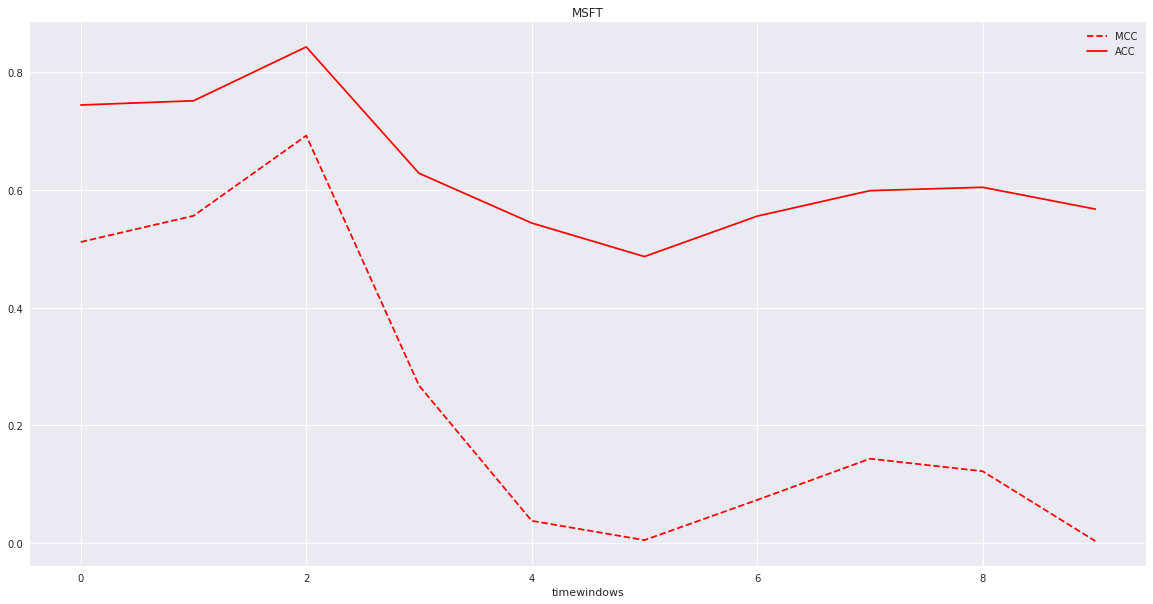




==================== FB ==================== 



trend:  -48   0
Best C:  0.05298316906283707  best gamma:  0.007880462815669913

tn, fp, fn, tp:  [123  47  63 323]
trend:  -35   0
Best C:  221.22162910704503  best gamma:  1.7433288221999873e-05

tn, fp, fn, tp:  [153  39  38 330]
trend:  -28   0
Best C:  13.738237958832638  best gamma:  0.0004893900918477494

tn, fp, fn, tp:  [159  38  33 332]
trend:  -7   0
Best C:  126.89610031679234  best gamma:  0.004520353656360245

tn, fp, fn, tp:  [176  77 137 178]
trend:  -1   0
Best C:  13.738237958832638  best gamma:  0.002592943797404667

tn, fp, fn, tp:  [165 105 137 163]
trend:  1   2
Best C:  72.78953843983153  best gamma:  0.0002807216203941176

tn, fp, fn, tp:  [183  87 207  92]
trend:  1   8
Best C:  221.22162910704503  best gamma:  1.7433288221999873e-05

tn, fp, fn, tp:  [129 124 153 161]
trend:  1   29
Best C:  57361.52510448681  best gamma:  5.2983169062837125e-05

tn, fp, fn, tp:  [ 99  98 102 262]
trend:  1   36
Best C:  1.48

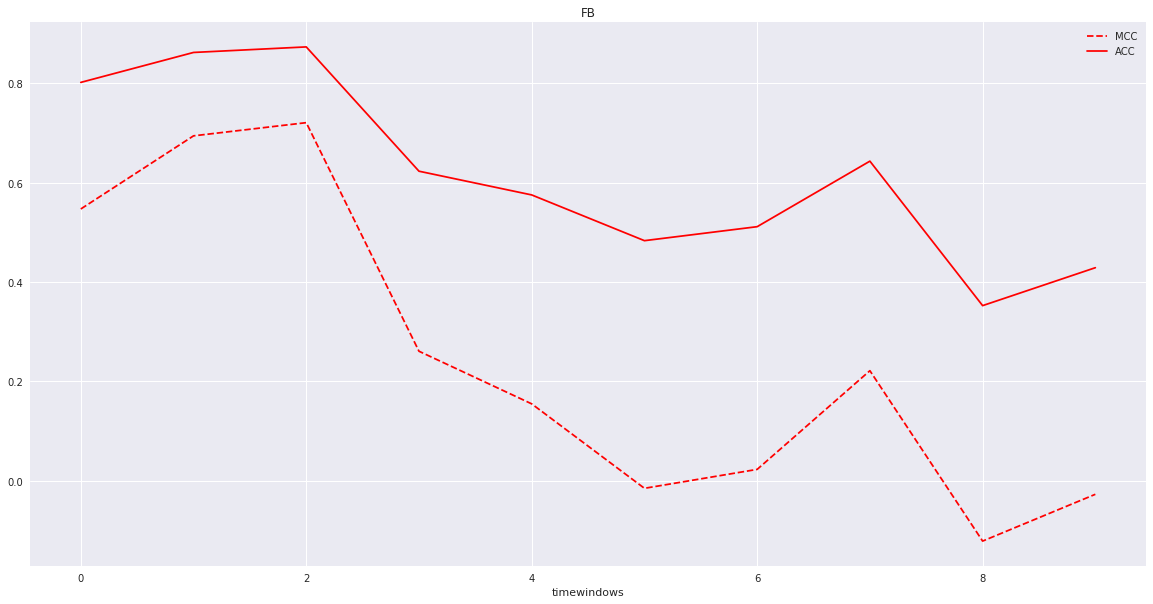




==================== INTC ==================== 



trend:  -48   0
Best C:  0.16102620275609392  best gamma:  0.02395026619987486

tn, fp, fn, tp:  [117  97  56 286]
trend:  -35   0
Best C:  4.520353656360245  best gamma:  0.0004893900918477494

tn, fp, fn, tp:  [143  67  76 274]
trend:  -28   0
Best C:  1.4873521072935119  best gamma:  0.0014873521072935117

tn, fp, fn, tp:  [153  62  76 271]
trend:  -7   0
Best C:  72.78953843983153  best gamma:  0.007880462815669913

tn, fp, fn, tp:  [ 96 155  61 256]
trend:  -1   0
Best C:  6210.169418915616  best gamma:  0.00016102620275609394

tn, fp, fn, tp:  [130 126 130 184]
trend:  1   2
Best C:  72.78953843983153  best gamma:  9.236708571873866e-05

tn, fp, fn, tp:  [132 124 135 178]
trend:  1   8
Best C:  2.592943797404667  best gamma:  0.07278953843983153

tn, fp, fn, tp:  [106 145 119 197]
trend:  1   29
Best C:  3562.2478902624443  best gamma:  3.039195382313195e-05

tn, fp, fn, tp:  [152  63 155 191]
trend:  1   36
Best C:  32903.445

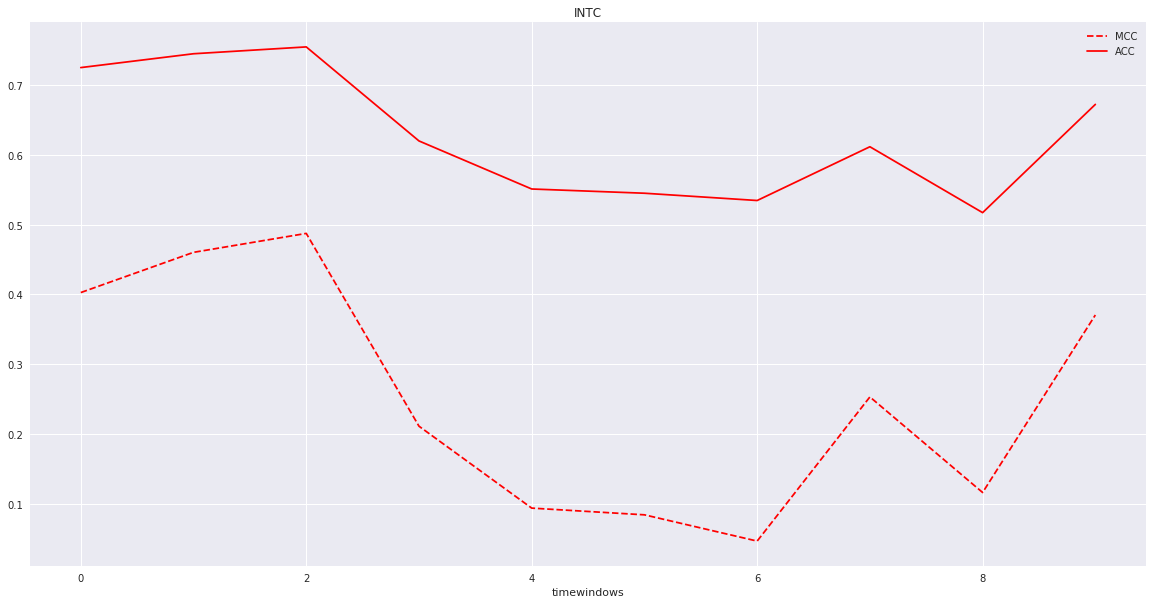




==================== CSCO ==================== 



trend:  -48   0
Best C:  2043.3597178569437  best gamma:  1e-05

tn, fp, fn, tp:  [214  38  40 263]
trend:  -35   0
Best C:  41.753189365604044  best gamma:  0.0008531678524172815

tn, fp, fn, tp:  [185  65  39 270]
trend:  -28   0
Best C:  221.22162910704503  best gamma:  5.2983169062837125e-05

tn, fp, fn, tp:  [210  63  36 252]
trend:  -7   0
Best C:  3562.2478902624443  best gamma:  1.7433288221999873e-05

tn, fp, fn, tp:  [155 107 106 200]
trend:  -1   0
Best C:  7.880462815669913  best gamma:  0.07278953843983153

tn, fp, fn, tp:  [118 138 129 185]
trend:  1   2
Best C:  221.22162910704503  best gamma:  0.02395026619987486

tn, fp, fn, tp:  [ 92 164 122 191]
trend:  1   8
Best C:  6210.169418915616  best gamma:  0.002592943797404667

tn, fp, fn, tp:  [ 84 178  83 222]
trend:  1   29
Best C:  0.4893900918477494  best gamma:  3.039195382313195e-05

tn, fp, fn, tp:  [ 87 186 140 148]
trend:  1   36
Best C:  0.16102620275609392  b

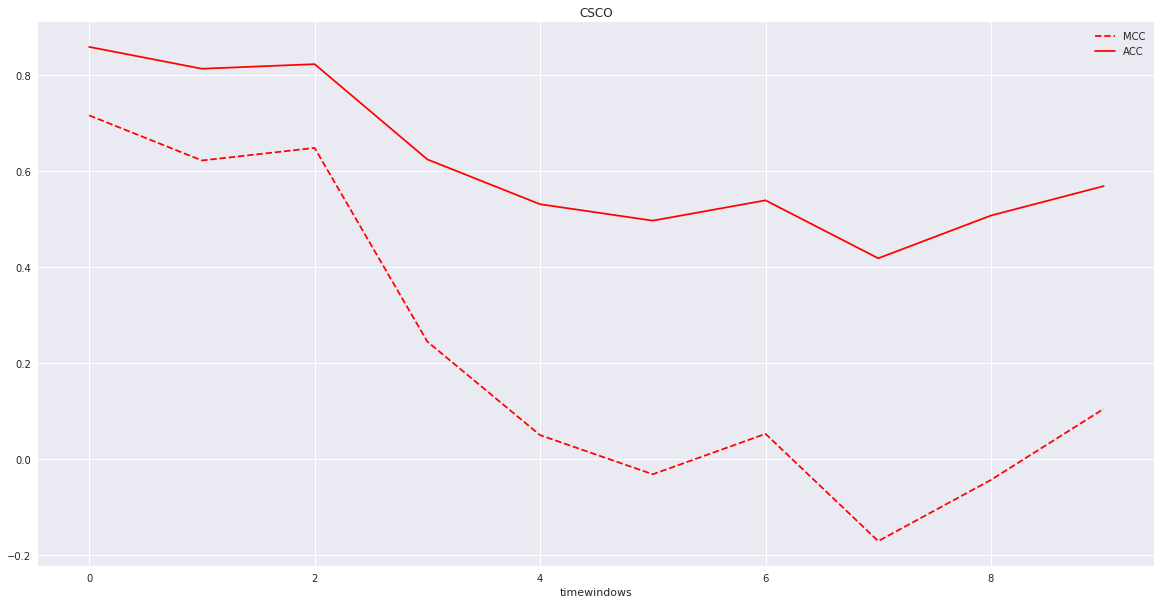




==================== CMCSA ==================== 



trend:  -48   0
Best C:  221.22162910704503  best gamma:  0.0002807216203941176

tn, fp, fn, tp:  [297  49  32 178]
trend:  -35   0
Best C:  10826.36733874054  best gamma:  1e-05

tn, fp, fn, tp:  [297  28  57 178]
trend:  -28   0
Best C:  0.853167852417281  best gamma:  0.004520353656360245

tn, fp, fn, tp:  [255  60  36 211]
trend:  -7   0
Best C:  10826.36733874054  best gamma:  5.2983169062837125e-05

tn, fp, fn, tp:  [227  88 113 140]
trend:  -1   0
Best C:  10826.36733874054  best gamma:  1e-05

tn, fp, fn, tp:  [173 120 145 132]
trend:  1   2
Best C:  2.592943797404667  best gamma:  0.6723357536499335

tn, fp, fn, tp:  [  1 292   1 275]
trend:  1   8
Best C:  672.3357536499335  best gamma:  0.02395026619987486

tn, fp, fn, tp:  [146 169 106 146]
trend:  1   29
Best C:  0.2807216203941177  best gamma:  0.12689610031679235

tn, fp, fn, tp:  [ 64 251  43 203]
trend:  1   36
Best C:  0.03039195382313198  best gamma:  0.072789538

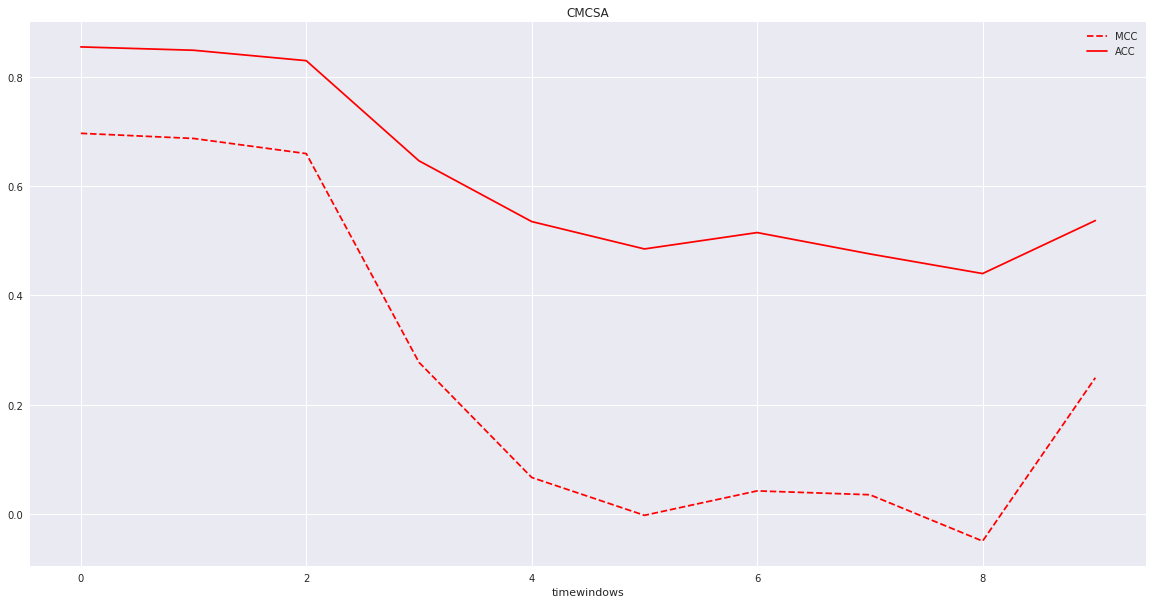




==================== NVDA ==================== 



trend:  -48   0
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Best C:  6210.169418915616  be

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Best C:  0.01  best gamma:  0.07278953843983153

tn, fp, fn, tp:  [131 148 101 179]
trend:  1   50
.

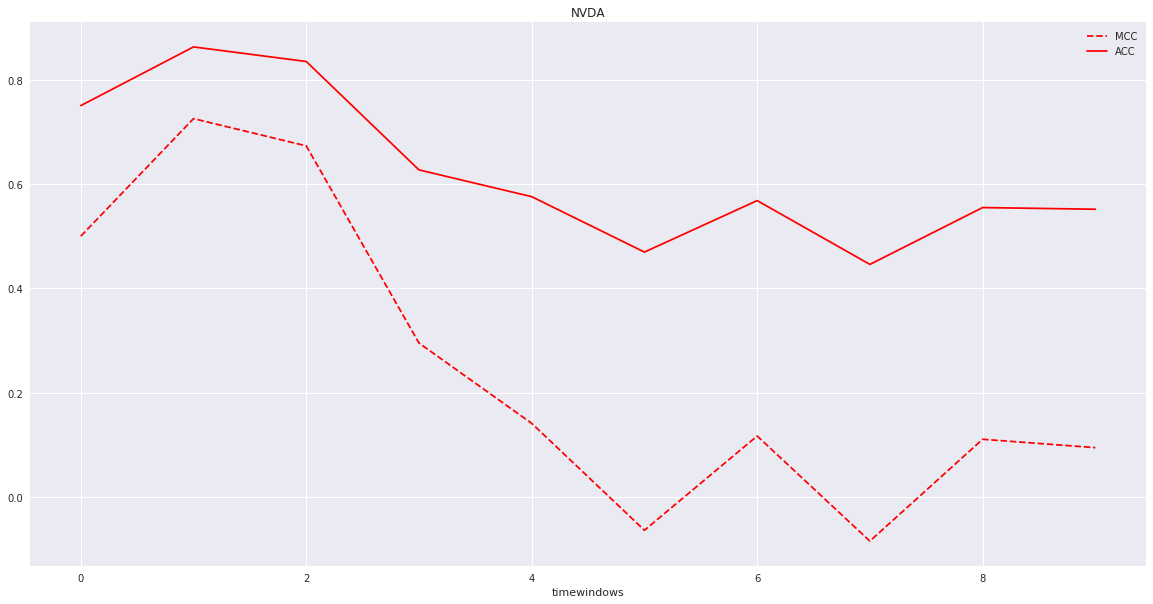




==================== NFLX ==================== 



trend:  -48   0
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Best C:  0.03039195382313198  

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Best C:  13.738237958832638  best gamma:  0.0002807216203941176

tn, fp, fn, tp:  [101  73  99 286]


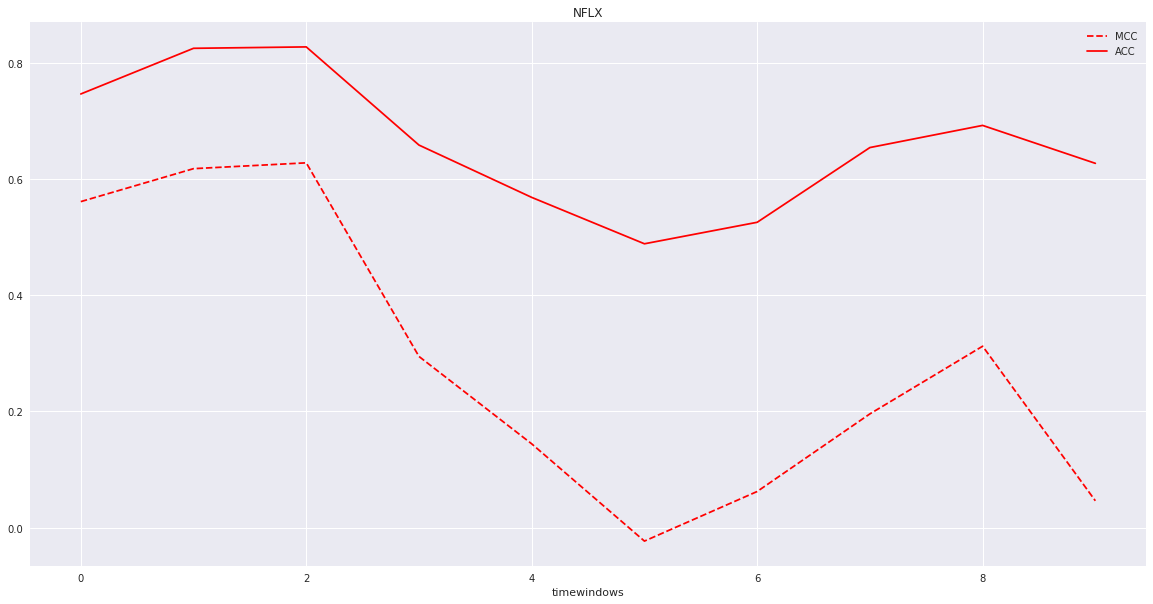

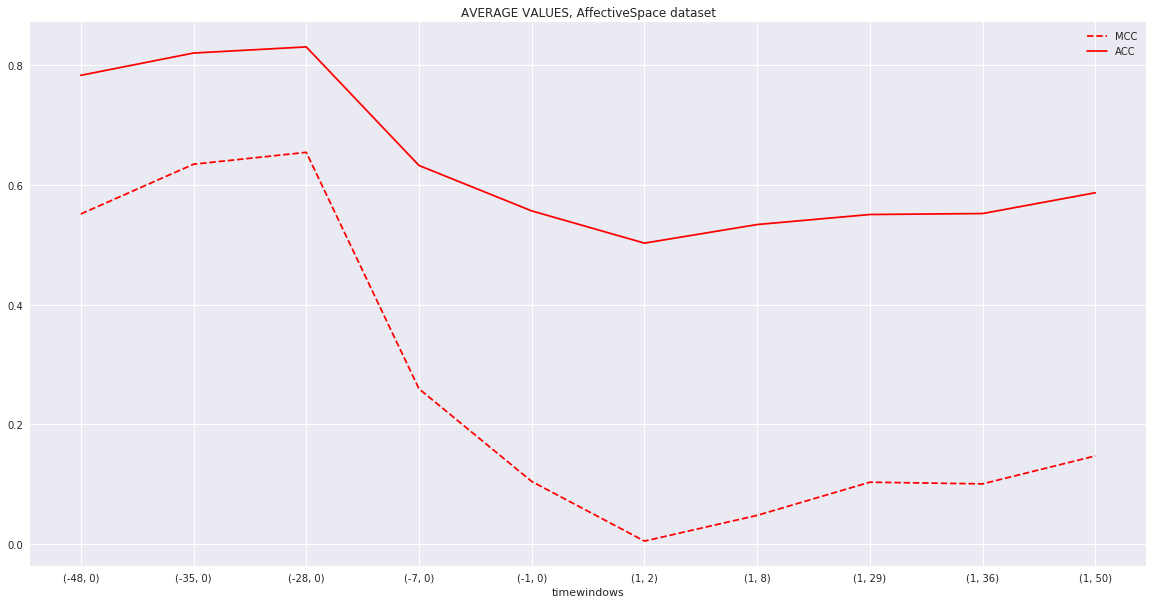

In [6]:
MCCs_avg = [0]*len(TREND_WINDOWs)
ACCs_avg = [0]*len(TREND_WINDOWs)
conf_matr_avg = np.zeros([2,2])
for ticker in tickers:
    print('\n\n\n==================== '+str(ticker)+' ==================== \n\n\n')
    MCCs = []
    ACCs = []
    ds = DatasetManager()
    ds.load_dataset(ticker = ticker, kind = kind_of_dataset,technicalFeatures=True)

    for (init, finish) in TREND_WINDOWs:
        print('trend: ',init,' ',finish)
        (x_tv,y_tv),(x_test,y_test),dates_test = ds.get_dataset_for_trend(init, finish)
        
        
        if(ticker, init, finish) in model_selection_values:
            (best_c,best_g) = model_selection_values[(ticker, init, finish)]
        else:
            (best_c,best_g) = cv(x_tv,y_tv)

        print('Best C: ',best_c,' best gamma: ',best_g)
        svm_model = svm.SVC(kernel='rbf', C=best_c, gamma=best_g)
        (x_tv,y_tv) = smote(x_tv,y_tv)
        svm_model.fit(x_tv,y_tv)
        acc = svm_model.score(x_test,y_test)
        y_pred = svm_model.predict(x_test)
        confmatrix = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = confmatrix.ravel()
        denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
        mcc = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom)
        ACCs.append(acc)
        MCCs.append(mcc)
        ACCs_avg[TREND_WINDOWs.index((init, finish))]+= acc/len(tickers)
        MCCs_avg[TREND_WINDOWs.index((init, finish))]+= mcc/len(tickers)
        print('\ntn, fp, fn, tp: ', confmatrix.ravel())

    plt.figure(figsize=(20,10))
    plt.plot(MCCs,'--r', label='MCC')
    plt.plot(ACCs,'r', label='ACC')
    plt.xlabel('timewindows')
    plt.title(ticker)
    plt.legend()
    plt.show() 

plt.figure(figsize=(20,10))
plt.plot(MCCs_avg,'--r', label='MCC')
plt.plot(ACCs_avg,'r', label='ACC')
plt.xlabel('timewindows')
plt.xticks(range(0,len(TREND_WINDOWs)), TREND_WINDOWs)
plt.title('AVERAGE VALUES, '+str(kind_of_dataset)+' dataset')
plt.legend()
plt.show() 


In [ ]:
## ========== quantile plots

MCCs_avg = np.zeros((len(TREND_WINDOWs),4))
ACCs_avg = np.zeros((len(TREND_WINDOWs),4))
for ticker in tickers:
    print('\n\n\n==================== '+str(ticker)+' ==================== \n\n\n')
    ds = DatasetManager()
    ds.load_dataset(ticker = ticker, kind = kind_of_dataset,technicalFeatures=True)
    for (init, finish) in TREND_WINDOWs:
        print('trend: ',init,' ',finish)
        (x,y), cum_ret = ds.get_dataset_for_trend(init, finish)

        #DATASET DIVISION:
        train=0.7
        nt=math.ceil(len(x)*train)
        x_tv = x[:nt]
        y_tv = y[:nt]
        x_test = x[nt:]
        y_test = y[nt:]
        cum_ret = cum_ret[nt:]

        best_mcc = -float(np.inf)
        best_c = 0
        best_g = 0
        for c in np.logspace(-2,5,10):
            for g in np.logspace(-5,2,10):
                print('.', end='')
                trainpoint=math.floor(len(x_tv)*0.50)
                dimval=math.floor(trainpoint*0.25)
                endval=trainpoint+dimval
                #Cross validation
                cvMCC = 0
                for i in range(0,4):
                    x_train=x_tv[0:trainpoint]
                    y_train=y_tv[0:trainpoint]
                    x_val=x_tv[trainpoint:endval]
                    y_val=y_tv[trainpoint:endval]
                    trainpoint=trainpoint+dimval
                    endval=endval+dimval
                    svm_model = svm.SVC(kernel='rbf', C=c, gamma=g)
                    svm_model.fit(x_train,y_train)
                    y_pred = svm_model.predict(x_val)
                    confmatrix = confusion_matrix(y_val, y_pred)
                    tn, fp, fn, tp = confmatrix.ravel()
                    denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
                    mcc = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom)
                    cvMCC += mcc/6

                if(cvMCC > best_mcc):
                    best_mcc = cvMCC
                    best_c = c
                    best_g = g


        svm_model = svm.SVC(kernel='rbf', C=best_c, gamma=best_g)
        svm_model.fit(x_tv,y_tv)
        y_pred = svm_model.predict(x_test)
        thresholds = np.linspace(0, max(np.absolute(cum_ret)), num=5)[:-1]
        
        for t in range(len(thresholds)):
            tresh = thresholds[t]
            y_pred_in_threshold = []
            y_test_in_threshold = []
            for i in range(len(cum_ret)):
                if(abs(cum_ret[i]) > tresh):
                    y_pred_in_threshold.append(y_pred[i])
                    y_test_in_threshold.append(y_test[i])
            tn = sum([1 if y_test_in_threshold[k] <= 0 and y_pred_in_threshold[k] <= 0 else 0 for k in range(len(y_test_in_threshold))])
            tp = sum([1 if y_test_in_threshold[k] > 0 and y_pred_in_threshold[k] > 0 else 0 for k in range(len(y_test_in_threshold))])
            fn = sum([1 if y_test_in_threshold[k] > 0 and y_pred_in_threshold[k] <= 0 else 0 for k in range(len(y_test_in_threshold))])
            fp = sum([1 if y_test_in_threshold[k] <= 0 and y_pred_in_threshold[k] >= 0 else 0 for k in range(len(y_test_in_threshold))])
            print(tp,tn,fn,fp)
            denom = (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)
            mcc = 0 if denom== 0 else (tp*tn -fp*fn)/sqrt(denom)
            acc = sum([1 if y_test_in_threshold[k]*y_pred_in_threshold[k]>0 else 0 for k in range(len(y_test_in_threshold))])/len(y_test_in_threshold)
            ACCs_avg[TREND_WINDOWs.index((init, finish))][t]+= acc/len(tickers)
            MCCs_avg[TREND_WINDOWs.index((init, finish))][t]+= mcc/len(tickers)
    print(ACCs_avg)


plt.figure(figsize=(20,10))
for (init, finish) in TREND_WINDOWs:
    plt.plot(MCCs_avg[TREND_WINDOWs.index((init, finish))], label='MCC_'+str(init)+'_'+str(finish))
    plt.xlabel('thresholds')
    plt.title('AVERAGE VALUES over quantiles, '+str(kind_of_dataset)+' dataset')
    plt.legend()
plt.savefig('onlyNewsSummary/ALL_TICKER_quantile_MCC.jpg')
plt.show() 

    
plt.figure(figsize=(20,10))
for (init, finish) in TREND_WINDOWs:
    plt.plot(ACCs_avg[TREND_WINDOWs.index((init, finish))], label='ACC_'+str(init)+'_'+str(finish))
    plt.xlabel('thresholds')
    plt.title('AVERAGE VALUES over quantiles, '+str(kind_of_dataset)+' dataset')
    plt.legend()
plt.savefig('onlyNewsSummary/ALL_TICKER_quantile_ACC.jpg')
plt.show() 
